# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">  Building RAG Application using Gemma 7B LLM & Faiss Vector Database </center>
***


Retrieval-Augmented Generation (RAG) is the concept of providing large language models (LLMs) with additional information from an external knowledge source. This allows them to generate more accurate and contextual answers while reducing hallucinations. In this article, we will provide a step-by-step guide to building a complete RAG application using the latest open-source LLM by Google Gemma 7B and open source vector database by Faiss.

### The notebook takes too much time to run so I have commented the code to eaily publish it!

#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b>Table of contents</b></div>

<div style="background-color: rgba(60, 121, 245, 0.03); padding:30px; font-size:15px; font-family: consolas;">
<ul>
    <li><a href="#1" target="_self" rel=" noreferrer nofollow">1. Getting Started & Setting Up Working Environment </a> </li>
    <li><a href="#2" target="_self" rel=" noreferrer nofollow">2. Download & Split the Cosmopedia Dataset </a></li>
    <li><a href="#3" target="_self" rel=" noreferrer nofollow">3. Generating Embedding with Sentence Transformers Model </a></li> 
    <li><a href="#4" target="_self" rel=" noreferrer nofollow">4. Store the Embeddings in the Faiss Vector Database </a></li>  
    <li><a href="#5" target="_self" rel=" noreferrer nofollow">5. Introduce & Use Gemma 7B LLM </a></li> 
    <li><a href="#6" target="_self" rel=" noreferrer nofollow">6. Querying the RAG Application </a></li>     
</ul>
</div>

***

<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 1. Getting Started & Setting Up Working Environment </b></div>

The first step in building an RAG application is to prepare the working environment. We will start with downloading the packages we will use in building the application:


In [1]:
# %pip install -q -U langchain torch transformers sentence-transformers datasets faiss-cpu


### Next, we will import the packages and libraries that will be used:

In [2]:
# import torch
# from datasets import load_dataset
# from langchain_community.document_loaders.csv_loader import CSVLoader
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain.embeddings import HuggingFaceEmbeddings
# from langchain.vectorstores import FAISS
# from transformers import AutoTokenizer
# from transformers import AutoTokenizer, pipeline
# from langchain import HuggingFacePipeline
# from langchain.chains import RetrievalQA


Retrieval-Augmented Generation (RAG) is the concept to provide LLMs with additional information from an external knowledge source. This allows them to generate more accurate and contextual answers while reducing hallucinations. 

### RAG has two main components:

1. Retrieval: The IR component acts as a search engine, sifting through a vast amount of text data (typically documents or passages) to identify the most relevant information about a given user query. This process involves techniques like dense passage retrieval, where the system retrieves not just documents but also specific text passages that align with the query’s intent.

2. Generation: The retrieved passages are fed into the LLM, which acts as a powerful language-processing engine. The LLM analyzes these passages and leverages its understanding of language to generate a response that addresses the user’s query comprehensively.

When a user asks a question to the LLM. Instead of asking the LLM directly, we generate embeddings for this query and then retrieve the relevant data from our knowledge library that is well maintained and then use that context to return the answer.

We use vector embeddings (numerical representations) to retrieve the requested document. Once the needed information is found from the vector databases, the result is returned to the user.

This largely reduces the possibility of hallucinations and updates the model without retraining the model, which is a costly process. Here’s a very simple diagram that shows the process.


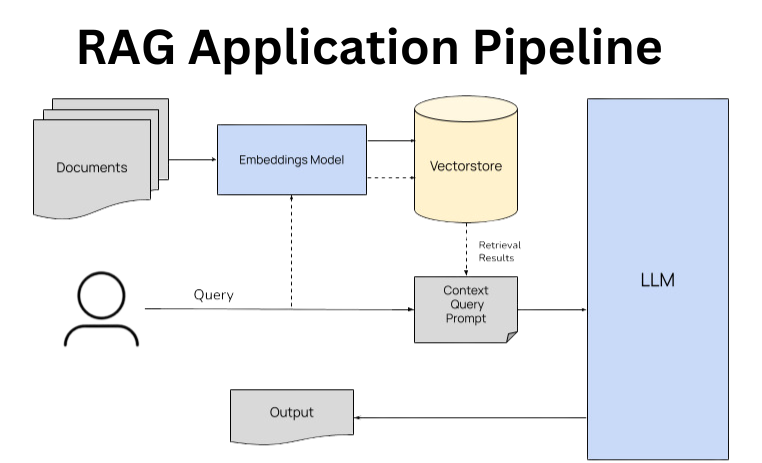

<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 2. Download & Split the Cosmopedia Dataset </b></div>


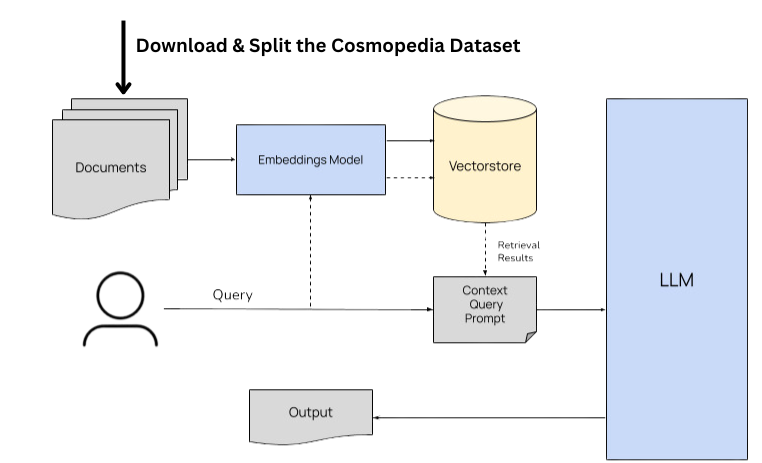


To build a cutting-edge RAG (Retrieval-Augmented Generation) application, we have strategically chosen the Cosmopedia dataset hosted by Hugging Face.
This meticulously compiled dataset comprises a diverse array of synthetic textual sources, ranging from textbooks and blog posts to narratives, social media entries, and WikiHow articles. Generated by the Mixtral-8x7B-Instruct-v0.1 model, [Cosmopedia](https://huggingface.co/datasets/HuggingFaceTB/cosmopedia) is a monumental collection, boasting over 30 million individual files and an astonishing 25 billion tokens.
Its sheer scale and comprehensiveness mark it as the largest open synthetic dataset currently available. It offers a wealth of material to fuel our innovative endeavors in natural language processing and generation.

The [Cosmopedia](https://huggingface.co/datasets/HuggingFaceTB/cosmopedia) dataset contains 8 subsets:
- auto_math_text: 1.95M rows
- khanacademy: 24.1k rows
- Openstax: 126k rows
- Stanford: 1.02M rows
- Stories: 4M rows
- web_samples_v1: 12.4M
- web_samples_v2: 10.3M rows
- wikiHow: 179K rows

We will continue working with the 'Stanford' subset. We'll load the dataset using the datasets library.


In [3]:
# data = load_dataset("HuggingFaceTB/cosmopedia", "stanford", split="train")

Next, we will convert it to a Pandas dataframe, and save it to a CSV file.

In [4]:
# data.to_csv("stanford_dataset.csv")
# data.head()

After saving the dataset on our system, we will use the LangChain CSVLoader method to load this dataset.

In [5]:
# loader = CSVLoader(file_path='/kaggle/working/stanford_dataset.csv')
# data = loader.load()

Now that the data is loaded, we need to split the documents inside the data into smaller chunks that can fit into your model's context window.

When you want to deal with long pieces of text, it is necessary to split them into chunks. As simple as this sounds, there is a lot of potential complexity here. Keep the semantically related pieces of text together.

LangChain has many built-in document transformers, making it easy to split, combine, filter, and otherwise manipulate documents. We will use the RecursiveCharacterTextSplitter which recursively tries to split by different characters to find one that works with. We will set the chunk size = 1000 and chunk overlap = 150.

In [6]:
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
# docs = text_splitter.split_documents(data)

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 3. Generating Embedding with Sentence Transformers Model </b></div>


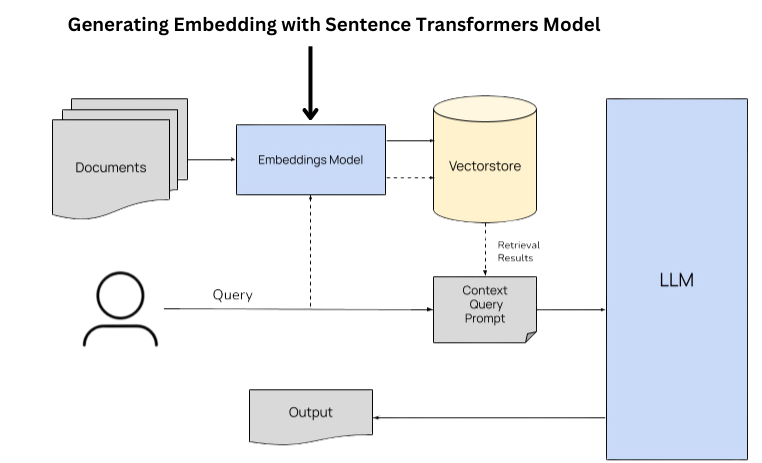

The next step is to generate embeddings for the loaded and split text. Generating embeddings is an essential step for building an RAG application as they encode semantic information about text, facilitating understanding of meaning and context crucial for both retrieval and generation processes which enhance retrieval accuracy by comparing query and document embeddings.

We will use the [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) embedding model from the [SentenceTransformers](https://www.sbert.net/) to generate the embeddings. First, we will initialize it using the code below:



In [7]:
# modelPath = "sentence-transformers/all-MiniLM-l6-v2"
# model_kwargs = {'device':'cpu'}
# encode_kwargs = {'normalize_embeddings': False}

# embeddings = HuggingFaceEmbeddings(
#  model_name=modelPath, 
#  model_kwargs=model_kwargs, 
#  encode_kwargs=encode_kwargs 
# )

Once we generate the embeddings we will need them stored in a vector database. Vector databases support indexing and clustering techniques optimized for high-dimensional data like embeddings, which can further improve retrieval efficiency and accuracy. We will use the Faiss vector database to save our embeddings.

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 4. Store the Embeddings in the Faiss Vector Database </b></div>


The embeddings are generated, but we need them to be stored in a vector database. We’ll be saving those embeddings in the FAISS vector store, which is a library for efficient similarity search and clustering dense vectors.


In [8]:
# db = FAISS.from_documents(docs, embeddings)

<a id="5"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 5. Introduce & Use Gemma 7B LLM </b></div>




[Gemma](https://blog.google/technology/developers/gemma-open-models/) is a family of 4 new LLM models by Google based on Gemini. It comes in two sizes: 2B and 7B parameters, each with base (pretrained) and instruction-tuned versions.
All the variants can be run on various types of consumer hardware, even without quantization, and have a context length of 8K tokens:
- [gemma-7b](https://huggingface.co/google/gemma-7b): Base 7B model.
- [gemma-7b-it](https://huggingface.co/google/gemma-7b-it): Instruction fine-tuned version of the base 7B model.
- [gemma-2b](https://huggingface.co/google/gemma-2b): Base 2B model.
- [gemma-2b-it](https://huggingface.co/google/gemma-2b-it): Instruction fine-tuned version of the base 2B model.

To use the [Gemma model](https://blog.google/technology/developers/gemma-open-models/), you should accept the terms on Hugging Face. After that, you must pass the Hugging Face token while logging in.

In [9]:
# from huggingface_hub import notebook_login
# notebook_login()

### Initialize the tokenizer with the model.

In [10]:
# from transformers import AutoModelForCausalLM, AutoTokenizer

# model = AutoModelForCausalLM.from_pretrained("google/gemma-7b")
# tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b", padding=True, truncation=True, max_length=512)

### Create a text generation pipeline.


In [11]:
# pipe = pipeline(
#     "text-generation", 
#     model=model, 
#     tokenizer=tokenizer,
#     return_tensors='pt',
#     max_length=512,
#     model_kwargs={"torch_dtype": torch.bfloat16},
#     device="cuda"
# )

### Initialize the LLM with pipeline and model kwargs.

In [12]:
# llm = HuggingFacePipeline(
#     pipeline=pipe,
#     model_kwargs={"temperature": 0.7, "max_length": 512},
# )


<a id="6"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 6. Querying Answers from the RAG Application </b></div>




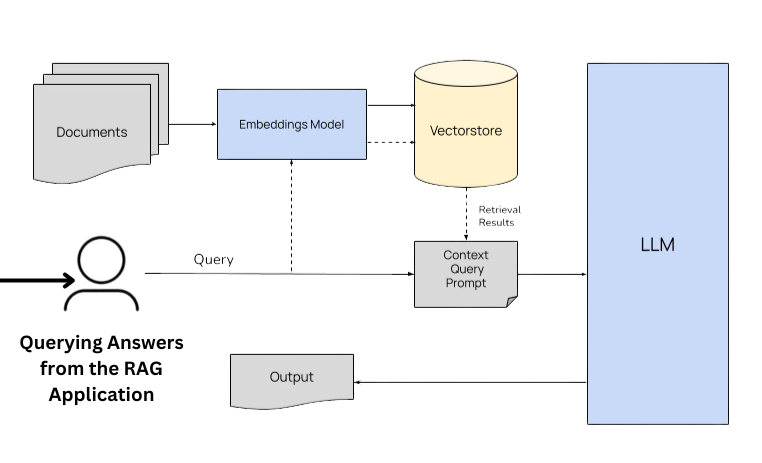

The final step is to generate the answers using both the vector store and the LLM. It will generate embeddings to the input query or question retrieve the context from the vector store, and feed this to the LLM to generate the answers:

In [13]:
# qa = RetrievalQA.from_chain_type(
#     llm=llm,
#     chain_type="stuff",
#     retriever=db.as_retriever()
# )

### Finally lets pass it a question and try it

In [14]:
# qa.invoke("Write an educational story for young children.")

# <div style="box-shadow: rgba(240, 46, 170, 0.4) -5px 5px inset, rgba(240, 46, 170, 0.3) -10px 10px inset, rgba(240, 46, 170, 0.2) -15px 15px inset, rgba(240, 46, 170, 0.1) -20px 20px inset, rgba(240, 46, 170, 0.05) -25px 25px inset; padding:20px; font-size:30px; font-family: consolas; display:fill; border-radius:15px; color: rgba(240, 46, 170, 0.7)"> <b> ༼⁠ ⁠つ⁠ ⁠◕⁠‿⁠◕⁠ ⁠༽⁠つ Thank You!</b></div>

<p style="font-family:verdana; color:rgb(34, 34, 34); font-family: consolas; font-size: 16px;"> 💌 Thank you for taking the time to read through my notebook. I hope you found it interesting and informative. If you have any feedback or suggestions for improvement, please don't hesitate to let me know in the comments. <br><br> 🚀 If you liked this notebook, please consider upvoting it so that others can discover it too. Your support means a lot to me, and it helps to motivate me to create more content in the future. <br><br> ❤️ Once again, thank you for your support, and I hope to see you again soon!</p>